# Diffusion

## Diffusion 이란?

이미지에 점진적으로 noise 를 더해가면 결국 완전한 noisy image 가 된다. 그렇다면 noisy image 에서 점진적으로 denoise 를 가하면 원하는 image 를 만들 수 있을 것이다.

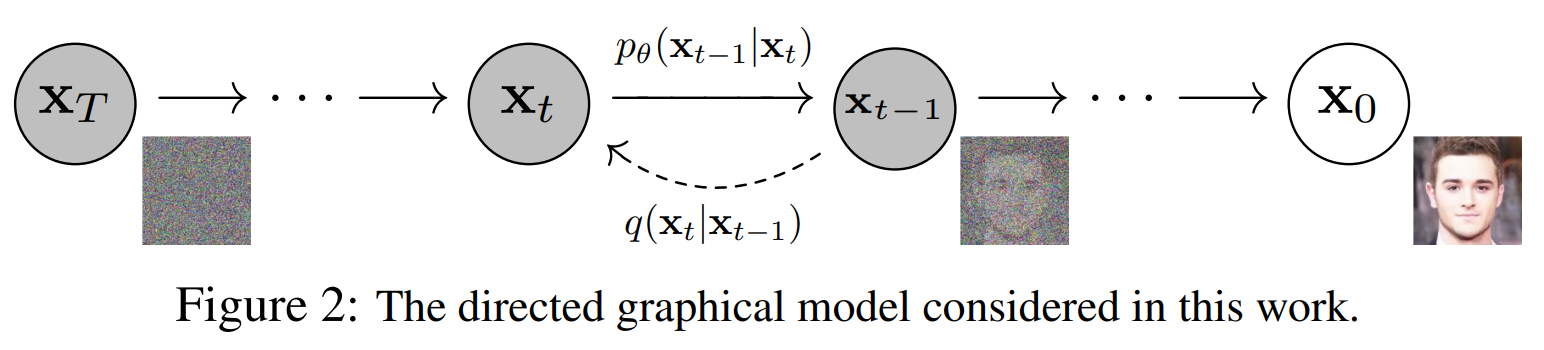

[Deep Unsupervised Learning using Nonequilibrium Thermodynamics : Diffusion model 에 대한 개념을 처음으로 제시](https://arxiv.org/abs/1503.03585)

[Denoising Diffusion Probabilistic Models : 해당 모델구조가 실용적임을 증명한 논문](https://arxiv.org/abs/2006.11239)

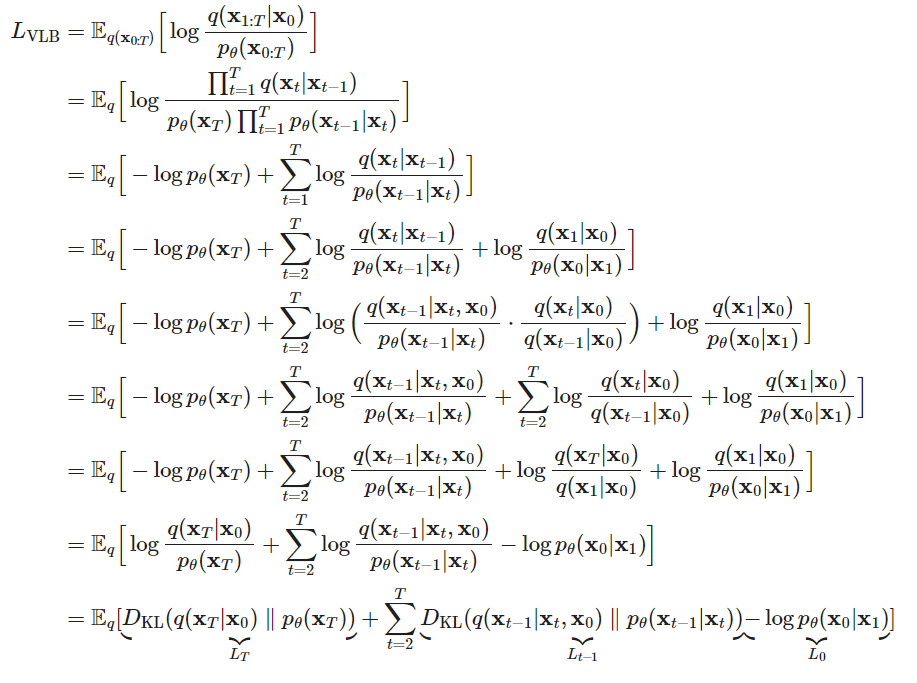

2번째 논문의 loss 증명식으로, 이런게 있구나 정도로 넘어가면 됩니다.

## Code 예제 : DDPM 을 통한 MNIST data 생성

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
batch_size = 128
lr = 2e-4
epoch = 100
timestep = 1000

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [7]:
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.79MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.37MB/s]


In [8]:
betas = torch.linspace(1e-4, 0.02, timestep).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [9]:
def extract(a, t, x_shape):
    t_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(t_size, *((1,) * (len(x_shape) - 1)))

In [10]:
class DDPM(nn.Module):
    def __init__(self):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64)
        )

        self.encoder1 = nn.Conv2d(1, 32, 3, padding=1)
        self.encoder2 = nn.Conv2d(32, 64, 3, padding=1)

        self.decoder1 = nn.Conv2d(64, 32, 3, padding=1)
        self.decoder2 = nn.Conv2d(32, 1, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x, t):
        t = t.float().unsqueeze(-1)
        t_emb = self.time_mlp(t)
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)

        x1 = self.relu(self.encoder1(x))
        x2 = self.relu(self.encoder2(x1))

        x2 = x2 + t_emb.expand(-1, 64, 28, 28)[:, :64, :, :]

        x3 = self.relu(self.decoder1(x2))
        output = self.decoder2(x3)

        return output

In [11]:
model = DDPM().to(device)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
loss_history = []

for i in range(epoch):
  i_loss = 0
  for step, (x_0, _) in enumerate(dataloader):
    optimizer.zero_grad()
    x_0 = x_0.to(device)

    t = torch.randint(0, timestep, (batch_size,), device=device).long()

    noise = torch.randn_like(x_0) # Ans noise 생성

    x_t = (
        extract(sqrt_alphas_cumprod, t, x_0.shape) * x_0 +
        extract(sqrt_one_minus_alphas_cumprod, t, x_0.shape) * noise)

    noise_pred = model(x_t, t)

    loss = F.mse_loss(noise_pred, noise)

    loss.backward()
    optimizer.step()

    i_loss += loss.item()

  avg_loss = i_loss / len(dataloader)
  loss_history.append(avg_loss)
  print(f"Epoch {i+1} Finished | Avg Loss: {avg_loss:.4f}")

Epoch 1 Finished | Avg Loss: 12.0299
Epoch 2 Finished | Avg Loss: 0.2518
Epoch 3 Finished | Avg Loss: 0.2014
Epoch 4 Finished | Avg Loss: 0.1740
Epoch 5 Finished | Avg Loss: 0.1435
Epoch 6 Finished | Avg Loss: 0.2843
Epoch 7 Finished | Avg Loss: 0.4558
Epoch 8 Finished | Avg Loss: 0.1450
Epoch 9 Finished | Avg Loss: 0.4865
Epoch 10 Finished | Avg Loss: 0.1236
Epoch 11 Finished | Avg Loss: 0.3328
Epoch 12 Finished | Avg Loss: 0.1276
Epoch 13 Finished | Avg Loss: 0.3664
Epoch 14 Finished | Avg Loss: 0.0847
Epoch 15 Finished | Avg Loss: 0.1402
Epoch 16 Finished | Avg Loss: 0.2455
Epoch 17 Finished | Avg Loss: 0.0771
Epoch 18 Finished | Avg Loss: 0.1386
Epoch 19 Finished | Avg Loss: 0.1540
Epoch 20 Finished | Avg Loss: 0.0760
Epoch 21 Finished | Avg Loss: 0.1327
Epoch 22 Finished | Avg Loss: 0.0877
Epoch 23 Finished | Avg Loss: 0.0812
Epoch 24 Finished | Avg Loss: 0.1077
Epoch 25 Finished | Avg Loss: 0.0811
Epoch 26 Finished | Avg Loss: 0.0823
Epoch 27 Finished | Avg Loss: 0.0650
Epoch 28 

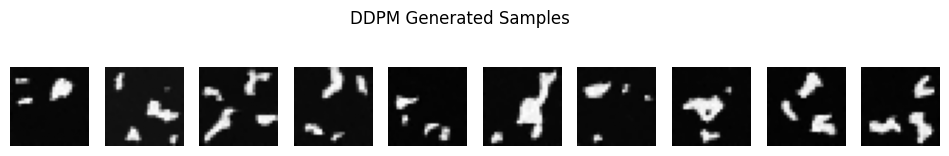

In [14]:
with torch.no_grad():
  img = torch.randn((10, 1, 28, 28), device=device)

  plt.figure(figsize=(12, 2))

  for i in range(timestep-1, -1, -1):
    t = torch.full((10,), i, device=device, dtype=torch.long)
    z = torch.randn_like(img) if i > 0 else torch.zeros_like(img)

    noise_pred = model(img, t)

    alpha_t = extract(alphas, t, img.shape)
    alpha_bar_t = extract(alphas_cumprod, t, img.shape)

    mean = (1 / torch.sqrt(alpha_t)) * (img - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * noise_pred)

    sigma_t = torch.sqrt(extract(betas, t, img.shape))

    img = mean + sigma_t * z
    for idx in range(10):
      plt.subplot(1, 10, idx+1)
      plt.imshow(img[idx].cpu().squeeze().numpy(), cmap='gray')
      plt.axis('off')
  plt.suptitle("DDPM Generated Samples")
  plt.show()

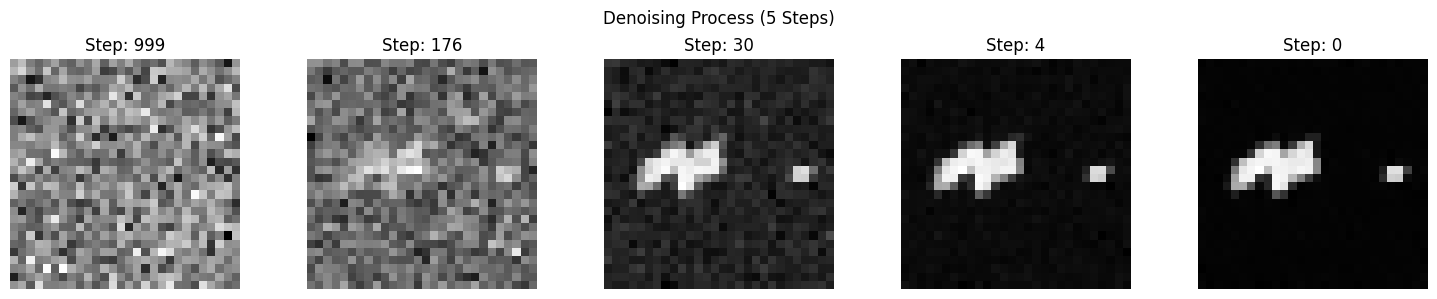

In [15]:
with torch.no_grad():
  model.eval()
  checkpoints = set((np.geomspace(1, timestep, 5) - 1).astype(int))

  img = torch.randn((1, 1, 28, 28), device=device)

  process_images = []
  process_steps = []
  for i in range(timestep - 1, -1, -1):
    t = torch.full((1,), i, device=device, dtype=torch.long)
    noise_pred = model(img, t)

    alpha_t = extract(alphas, t, img.shape)
    alpha_bar_t = extract(alphas_cumprod, t, img.shape)
    beta_t = extract(betas, t, img.shape)

    mean = (1 / torch.sqrt(alpha_t)) * (
        img - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * noise_pred)

    if i > 0:
        z = torch.randn_like(img)
        sigma_t = torch.sqrt(beta_t)
        img = mean + sigma_t * z
    else:
        img = mean

    if i in checkpoints:
        process_images.append(img.cpu().squeeze().numpy())
        process_steps.append(i)

  plt.figure(figsize=(15, 3))

  for idx, (step, image) in enumerate(zip(process_steps, process_images)):
    plt.subplot(1, 5, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Step: {step}")
    plt.axis('off')

  plt.suptitle("Denoising Process (5 Steps)")
  plt.tight_layout()
  plt.show()

## Code 예제 : Stable Diffusion model

어쩌면 가장 유명할 Diffusion model. 모델 전체가 오픈소스로 공개됨

[GitHub 링크](https://github.com/CompVis/stable-diffusion)

In [14]:
!pip install diffusers accelerate

In [15]:
from diffusers import StableDiffusionPipeline
from IPython.display import display

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

In [18]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", dtype=torch.float16)
pipe = pipe.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
prompt = "Cowboy"

  0%|          | 0/50 [00:00<?, ?it/s]

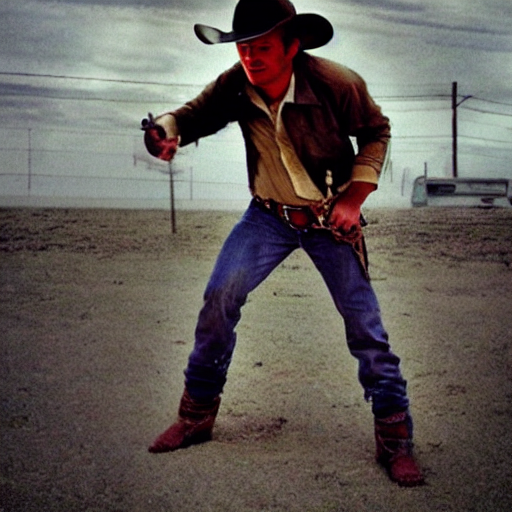

In [28]:
image = pipe(prompt).images[0]
display(image)